In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs,\
                                  pad_seqs_2step, pad_seqs_1step, calculate_output, onehot2seq 

from sklearn.metrics import r2_score

In [2]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]


def train(sequence,label,model,optimizer,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs

def test_preds(model, testdata, hidden_size, suffix = ''):
    model.eval()
    preds = []
    labs = []
    trials = []
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                preds.append(y_hat.detach().item())
                labs.append(y[i].detach().item())
            trials.append(str(onehot2seq(x)))
    df = pd.DataFrame({'trial':trials, 'label'+suffix:labs, 'pred'+suffix: preds})
    return df 


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

def run_sim(train_trials, test_trials):
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials, test_trials, epochs)
    return loss1, acc1, model

def run_sims(i, train_trials, test_trials):
    print('########## rep', i, '#########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, train_trials[0], test_trials, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, train_trials[1], test_trials, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])
    return losses, accs, model


def seq_acc(model, testdata, hidden_size, rep = 10, verbose = False):

    model.eval()
    trials = []
    accs = []
    for j, (x,y) in enumerate(testdata):
        for i in range(len(x)):
            hidden = torch.zeros(1, hidden_size)[0]
            for step in x[i]:
                hidden, y_hat = model.get_activations(step,hidden)
            correct = sum(torch.round(y[i]) == torch.round(y_hat)).item() 
            accs.append(float(correct))
            curr_trial = onehot2seq(x)
            trials.append(curr_trial)
    df = pd.DataFrame({'trial':trials, 'acc':accs})
    df['trial'] = df['trial'].apply(str)
           
    return df.sort_values(by = 'acc',ascending = False)

def change_padder(seqs, cue_dict, xval):
    """ changes value of X from zero to a new value
        and recalculates sequence output"""
    cue_dict['X'] = xval
    inps = [s[:-1] for s in seqs]
    for inp in inps:
        inp.append(calculate_output(inp, cue_dict, bidmas = False))

    return inps, cue_dict


# ----------
# plotting
# ----------

def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue']
    loss_labs = ['loss_with_primitive', 'loss_without_primitive']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = loss_labs[i], color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=10)

In [3]:
# params

num_classes = 22
batchsize=1
# specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20


# Trigrams: Addition

In [4]:
def exp1(num_inputs):    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    all_syms = total_syms[:num_inputs]
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    cue_dict = {'X':0}
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    # generate trials
    p = pad_seqs_1step(all_syms, cue_dict)
    train_sims = all_syms[1:]
    trainseqs = generate_sequences(['+'], train_sims, len_seq = 1, cue_dict = cue_dict, init_values = train_sims)
    testseqs = generate_sequences(['+'], all_syms, len_seq = 1, cue_dict = cue_dict, init_values = all_syms)
    # randomly select a test trial to train non_primitive on
    rand_trial = random.choice(testseqs)
    trainseqs_np = trainseqs + [rand_trial]
    # remove any trian trials from test set
    for val in trainseqs_np:
        if val in testseqs:
            testseqs.remove(val)
            
    # load data for primitive training
    padtrain = p + pad_seqs_2step(trainseqs)
    train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    padtrain_np = pad_seqs_2step(trainseqs_np)
    train_inputs = convert_seq2inputs(padtrain_np, num_classes=num_classes, seq_len=5)
    trainset_np = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    padtest = pad_seqs_2step(testseqs)
    test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    model2 = copy.deepcopy(model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)

    
    optimizer = torch.optim.Adam(model2.parameters(), lr=learningRate)
    loss2, acc2 = run_acc(model2,optimizer,criterion, trainset_np, [trainset_np, testset], epochs)

    return {'cue_dict': cue_dict, 'losses': loss1, 'accs': acc1, 'model': model, 'testset': testset,
           'losses_np': loss2, 'accs_np': acc2, 'model_np': model2}

In [5]:
def exp2(num_inputs):
    
    """ check if X = 0 value has unique primitive effect; 
    or if there is the same behaviour with X = some const """
    
    total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
    all_syms = total_syms[:num_inputs]
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    # randomly select values for each input
    cue_dict = {'X':0}
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # generate trials
    p = pad_seqs_1step(all_syms, cue_dict)
    train_sims = all_syms[1:]
    trainseqs = generate_sequences(['+'], train_sims, len_seq = 1, cue_dict = cue_dict, init_values = train_sims)
    testseqs = generate_sequences(['+'], all_syms, len_seq = 1, cue_dict = cue_dict, init_values = all_syms)
    
    # randomly select a test trial to train non_primitive on
    rand_trial = random.choice(testseqs)
    trainseqs_np = trainseqs + [rand_trial]
    
    # remove any trian trials from test set
    for val in trainseqs_np:
        if val in testseqs:
            testseqs.remove(val)
            
    # load data for primitive training
    padtrain = p + pad_seqs_2step(trainseqs)
    train_inputs = convert_seq2inputs(padtrain, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    padtrain_np = pad_seqs_2step(trainseqs_np)
    train_inputs = convert_seq2inputs(padtrain_np, num_classes=num_classes, seq_len=5)
    trainset_np = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    padtest = pad_seqs_2step(testseqs)
    test_inputs = convert_seq2inputs(padtest, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    
    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    model2 = copy.deepcopy(model)
    model3 = copy.deepcopy(model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)

    # run without primitive training
    optimizer = torch.optim.Adam(model2.parameters(), lr=learningRate)
    loss2, acc2 = run_acc(model2,optimizer,criterion, trainset_np, [trainset_np, testset], epochs)
    
    # change value of padder
    xval = random.randint(1, 9)
    padtrain_x, cd = change_padder(padtrain, cue_dict, xval)
    train_inputs = convert_seq2inputs(padtrain_x, num_classes=num_classes, seq_len=5)
    trainset_x = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    padtest_x, cd = change_padder(padtest, cue_dict, xval)
    test_inputs = convert_seq2inputs(padtest_x, num_classes=num_classes, seq_len=5)
    testset_x = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    
    optimizer = torch.optim.Adam(model3.parameters(), lr=learningRate)
    loss3, acc3 = run_acc(model3,optimizer,criterion, trainset_x, [trainset_x, testset_x], epochs)
    
    return {'cue_dict': cue_dict, 'losses': loss1, 'accs': acc1, 'model': model, 'testset': testset,\
           'losses_np': loss2, 'accs_np': acc2, 'model_np': model2,\
           'losses_x': loss3, 'accs_x': acc3, 'model_x': model3, 'Xval': xval, 'testsetX': testset_x}

In [6]:
def run_exp1(trainseqs, testseqs):

    # load data for primitive training
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    model2 = copy.deepcopy(model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset], epochs)

    # change value of padder
    xval = random.randint(1, 9)
    train_x, cd = change_padder(trainseqs, cue_dict, xval)
    train_inputs = convert_seq2inputs(train_x, num_classes=num_classes, seq_len=5)
    trainset_x = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

    test_x, cd = change_padder(testseqs, cue_dict, xval)
    test_inputs = convert_seq2inputs(test_x, num_classes=num_classes, seq_len=5)
    testset_x = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    optimizer = torch.optim.Adam(model2.parameters(), lr=learningRate)
    loss2, acc2 = run_acc(model2,optimizer,criterion, trainset_x, [trainset_x, testset_x], epochs)

    return {'loss1':loss1, 'acc1':acc1, 'mod1': model, 'test1': testset,
            'loss2':loss2, 'acc2':acc2, 'mod2': model2, 'test2': testset_x}

## Exp 1

---

In [7]:
num_inputs = 2

total_syms = ['X','A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs-1)
# randomly select values for each input
cue_dict = {'X':0}
for i, s in enumerate(all_syms[1:]):
    cue_dict[s] = input_vals[i]

# generate trials
p = pad_seqs_1step(all_syms, cue_dict)
train_sims = all_syms[0]
if num_inputs > 2:
    train_sims += all_syms[2:] 
#trainseqs = generate_sequences(['+'], train_sims, len_seq = 2, cue_dict = cue_dict, init_values = train_sims)
trainseqs = p
testseqs = generate_sequences(['+'], all_syms, len_seq = 2, cue_dict = cue_dict, init_values = all_syms)

# remove any trian trials from test set
for val in trainseqs:
    if val in testseqs:
        testseqs.remove(val)



In [98]:
all_seqs = generate_sequences(['+'], all_syms, len_seq = 2, cue_dict = cue_dict, init_values = all_syms)

tr1 = all_seqs[0,1,-2,-1]
ts1 = 

In [74]:
# params

num_classes = 22
batchsize=1
# specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.001

time:  4.1921519835789995


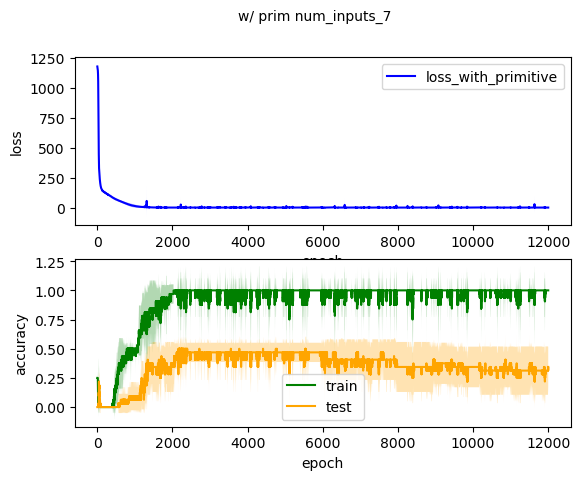

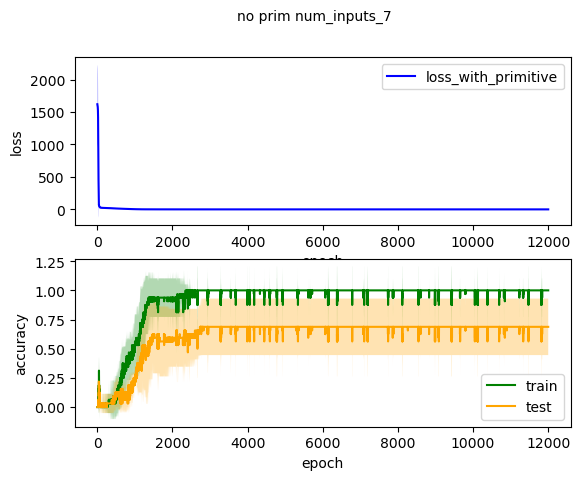

In [203]:
num_sims = 8
epochs = 12000


trainseqs = [['X', ('+', 'X'), ('+', 'X'), 0],
             ['A', ('+', 'X'), ('+', 'X'), 14],
             ['X', ('+', 'X'), ('+', 'A'), 14],
            ['A', ('+', 'A'), ('+', 'X'), 28]]

             

testseqs = [
             ['A', ('+', 'X'), ('+', 'A'), 28],
            ['X', ('+', 'A'), ('+', 'X'), 14],
            
            ['A', ('+', 'A'), ('+', 'A'), 42],
            ['X', ('+', 'A'), ('+', 'A'), 28]
             ]

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss1'] for r in res])
acc_train = np.array([r['acc1'][:,0] for r in res]).T
acc_test = np.array([r['acc1'][:,1] for r in res]).T
mods = [r['mod1'] for r in res]
tests = [r['test1'] for r in res]
lossesx = np.hstack([r['loss2'] for r in res])
acc_trainx = np.array([r['acc2'][:,0] for r in res]).T
acc_testx = np.array([r['acc2'][:,1] for r in res]).T
modsx = [r['mod2'] for r in res]
testsx = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plotNNs([lossesx], [acc_trainx, acc_testx], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'no prim num_inputs_'+str(7), shift = 0)


In [75]:
num_sims = 8
epochs = 6000


trainseqs = [['X', ('+', 'X'), ('+', 'X'), 0],
             ['A', ('+', 'X'), ('+', 'X'), 14],
            ['X', ('+', 'A'), ('+', 'X'), 14],
            ['X', ('+', 'X'), ('+', 'A'), 14],
            ['A', ('+', 'A'), ('+', 'A'), 42],
            ['X', ('+', 'A'), ('+', 'A'), 28]]

             

testseqs = [['A', ('+', 'A'), ('+', 'X'), 28],
             ['A', ('+', 'X'), ('+', 'A'), 28],
             ]

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss1'] for r in res])
acc_train = np.array([r['acc1'][:,0] for r in res]).T
acc_test = np.array([r['acc1'][:,1] for r in res]).T
mods = [r['mod1'] for r in res]
tests = [r['test1'] for r in res]
lossesx = np.hstack([r['loss2'] for r in res])
acc_trainx = np.array([r['acc2'][:,0] for r in res]).T
acc_testx = np.array([r['acc2'][:,1] for r in res]).T
modsx = [r['mod2'] for r in res]
testsx = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plotNNs([lossesx], [acc_trainx, acc_testx], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'no prim num_inputs_'+str(7), shift = 0)


time:  2.551313348611196


time:  2.2967012484868365


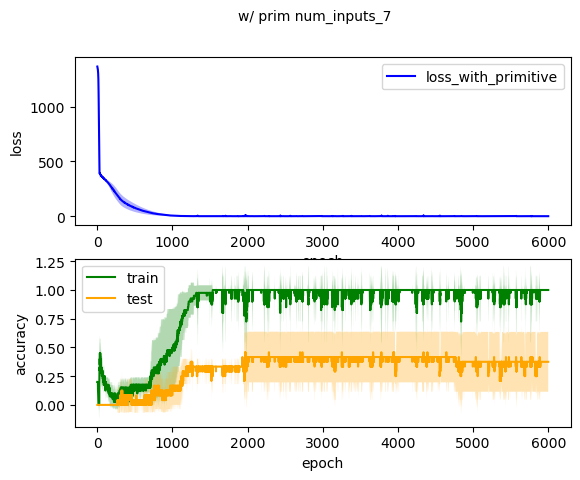

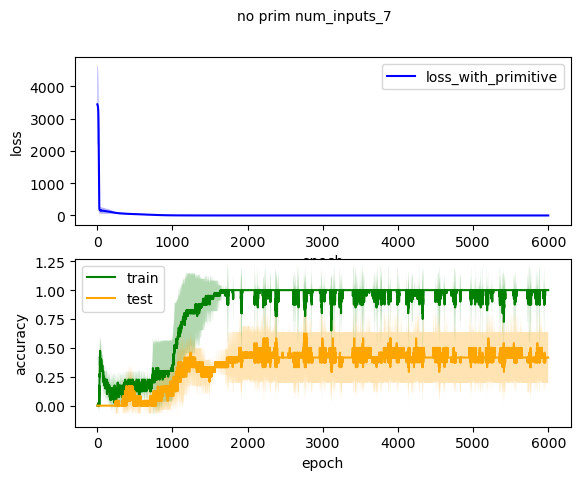

In [78]:
trainseqs = [['X', ('+', 'X'), ('+', 'X'), 0],
             ['A', ('+', 'X'), ('+', 'X'), 14],
            ['X', ('+', 'A'), ('+', 'X'), 14],
            ['X', ('+', 'X'), ('+', 'A'), 14],
            ['X', ('+', 'A'), ('+', 'A'), 28]]

             

testseqs = [['A', ('+', 'A'), ('+', 'X'), 28],
             ['A', ('+', 'X'), ('+', 'A'), 28],
            ['A', ('+', 'A'), ('+', 'A'), 42]
             ]

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss1'] for r in res])
acc_train = np.array([r['acc1'][:,0] for r in res]).T
acc_test = np.array([r['acc1'][:,1] for r in res]).T
mods = [r['mod1'] for r in res]
tests = [r['test1'] for r in res]
lossesx = np.hstack([r['loss2'] for r in res])
acc_trainx = np.array([r['acc2'][:,0] for r in res]).T
acc_testx = np.array([r['acc2'][:,1] for r in res]).T
modsx = [r['mod2'] for r in res]
testsx = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plotNNs([lossesx], [acc_trainx, acc_testx], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'no prim num_inputs_'+str(7), shift = 0)


time:  2.3972077488899233


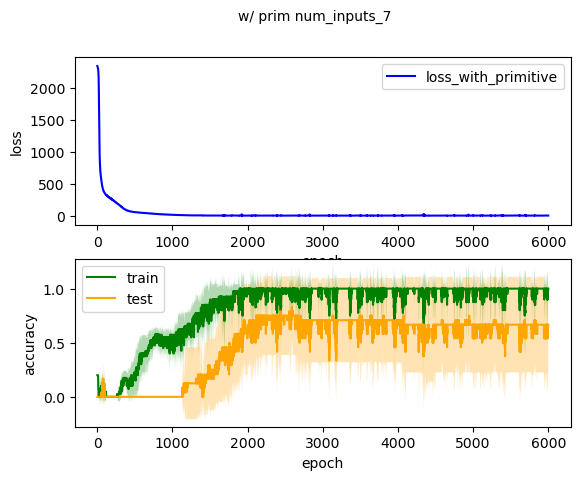

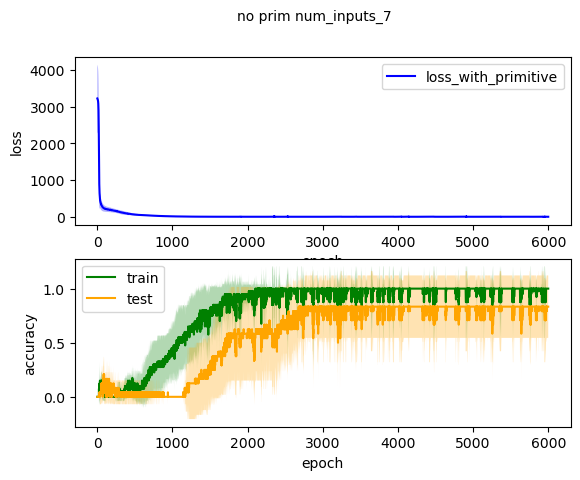

In [87]:
trainseqs = [['X', ('+', 'X'), ('+', 'X'), 0],
             ['A', ('+', 'X'), ('+', 'X'), 14],
            ['X', ('+', 'A'), ('+', 'X'), 14],
            ['X', ('+', 'X'), ('+', 'A'), 14],
            ['A', ('+', 'A'), ('+', 'A'), 42]]

             

testseqs = [['A', ('+', 'A'), ('+', 'X'), 28],
             ['A', ('+', 'X'), ('+', 'A'), 28],
            ['X', ('+', 'A'), ('+', 'A'), 28]
             ]

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss1'] for r in res])
acc_train = np.array([r['acc1'][:,0] for r in res]).T
acc_test = np.array([r['acc1'][:,1] for r in res]).T
mods = [r['mod1'] for r in res]
tests = [r['test1'] for r in res]
lossesx = np.hstack([r['loss2'] for r in res])
acc_trainx = np.array([r['acc2'][:,0] for r in res]).T
acc_testx = np.array([r['acc2'][:,1] for r in res]).T
modsx = [r['mod2'] for r in res]
testsx = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plotNNs([lossesx], [acc_trainx, acc_testx], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'no prim num_inputs_'+str(7), shift = 0)


time:  2.117356371879578


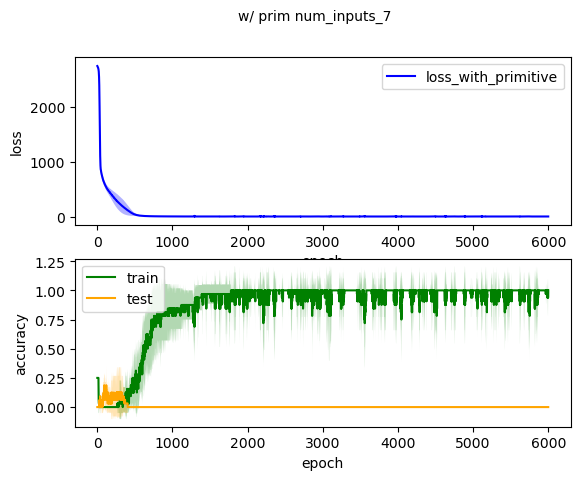

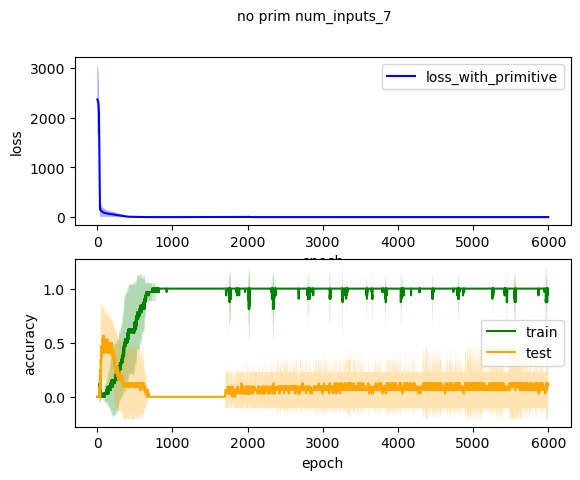

In [100]:
trainseqs = [['X', ('+', 'X'), ('+', 'X'), 0],
             ['A', ('+', 'X'), ('+', 'X'), 14],
             ['X', ('+', 'A'), ('+', 'A'), 28],
            ['A', ('+', 'A'), ('+', 'A'), 42]]

             

testseqs = [['A', ('+', 'A'), ('+', 'X'), 28],
             ['A', ('+', 'X'), ('+', 'A'), 28],
             ['X', ('+', 'A'), ('+', 'X'), 14],
            ['X', ('+', 'X'), ('+', 'A'), 14]
             ]

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss1'] for r in res])
acc_train = np.array([r['acc1'][:,0] for r in res]).T
acc_test = np.array([r['acc1'][:,1] for r in res]).T
mods = [r['mod1'] for r in res]
tests = [r['test1'] for r in res]
lossesx = np.hstack([r['loss2'] for r in res])
acc_trainx = np.array([r['acc2'][:,0] for r in res]).T
acc_testx = np.array([r['acc2'][:,1] for r in res]).T
modsx = [r['mod2'] for r in res]
testsx = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plotNNs([lossesx], [acc_trainx, acc_testx], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'no prim num_inputs_'+str(7), shift = 0)


time:  2.0181989351908367


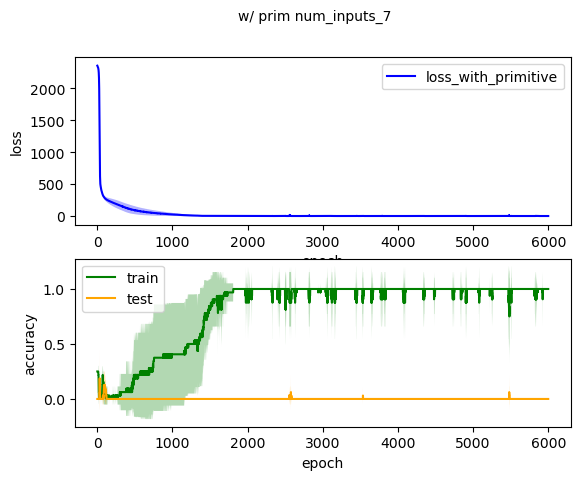

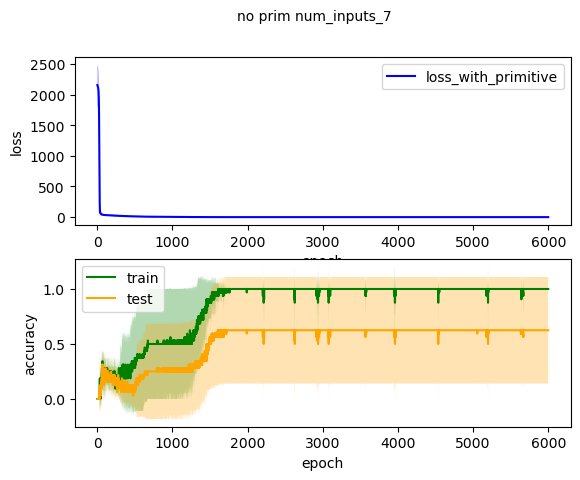

In [101]:
trainseqs = [['X', ('+', 'X'), ('+', 'X'), 0],
             ['A', ('+', 'A'), ('+', 'X'), 28],
             ['A', ('+', 'X'), ('+', 'A'), 28],
             ['X', ('+', 'A'), ('+', 'A'), 28]
             ]

             

testseqs = [
             ['X', ('+', 'A'), ('+', 'X'), 14],
            ['X', ('+', 'X'), ('+', 'A'), 14],
            ['A', ('+', 'X'), ('+', 'X'), 14],
             
            ['A', ('+', 'A'), ('+', 'A'), 42]
             ]

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss1'] for r in res])
acc_train = np.array([r['acc1'][:,0] for r in res]).T
acc_test = np.array([r['acc1'][:,1] for r in res]).T
mods = [r['mod1'] for r in res]
tests = [r['test1'] for r in res]
lossesx = np.hstack([r['loss2'] for r in res])
acc_trainx = np.array([r['acc2'][:,0] for r in res]).T
acc_testx = np.array([r['acc2'][:,1] for r in res]).T
modsx = [r['mod2'] for r in res]
testsx = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plotNNs([lossesx], [acc_trainx, acc_testx], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'no prim num_inputs_'+str(7), shift = 0)


time:  2.283585480848948


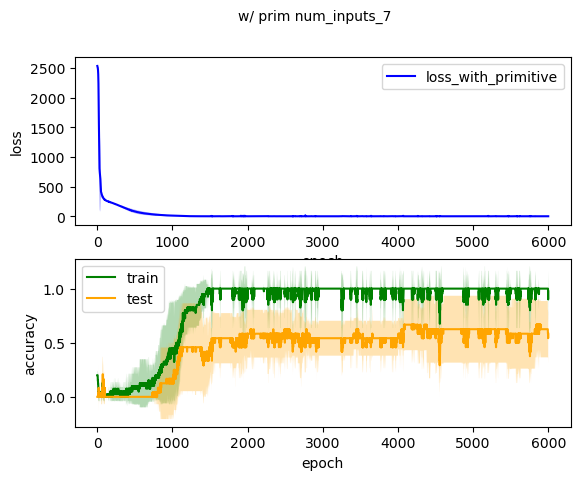

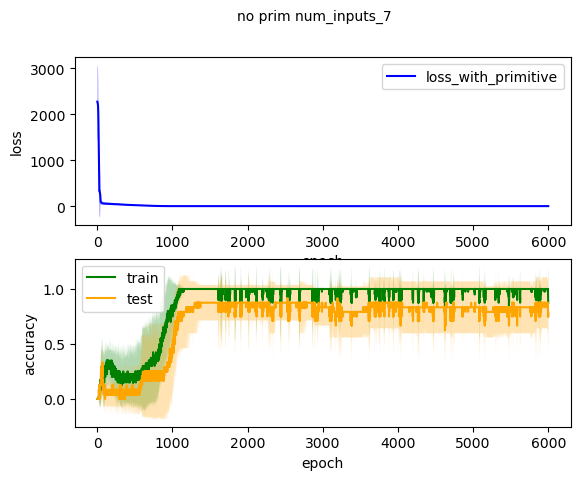

loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.1 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.3 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 1.6 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 1.4 
loss: 4.9 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.5 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 
loss: 0.0 


In [102]:
trainseqs = [['X', ('+', 'X'), ('+', 'X'), 0],
             ['A', ('+', 'A'), ('+', 'X'), 28],
             ['A', ('+', 'X'), ('+', 'A'), 28],
             ['X', ('+', 'A'), ('+', 'A'), 28],
             ['X', ('+', 'A'), ('+', 'X'), 14]
             ]

             

testseqs = [
            ['X', ('+', 'X'), ('+', 'A'), 14],
            ['A', ('+', 'X'), ('+', 'X'), 14],
            ['A', ('+', 'A'), ('+', 'A'), 42]
             ]

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss1'] for r in res])
acc_train = np.array([r['acc1'][:,0] for r in res]).T
acc_test = np.array([r['acc1'][:,1] for r in res]).T
mods = [r['mod1'] for r in res]
tests = [r['test1'] for r in res]
lossesx = np.hstack([r['loss2'] for r in res])
acc_trainx = np.array([r['acc2'][:,0] for r in res]).T
acc_testx = np.array([r['acc2'][:,1] for r in res]).T
modsx = [r['mod2'] for r in res]
testsx = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plotNNs([lossesx], [acc_trainx, acc_testx], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'no prim num_inputs_'+str(7), shift = 0)


time:  2.104039204120636


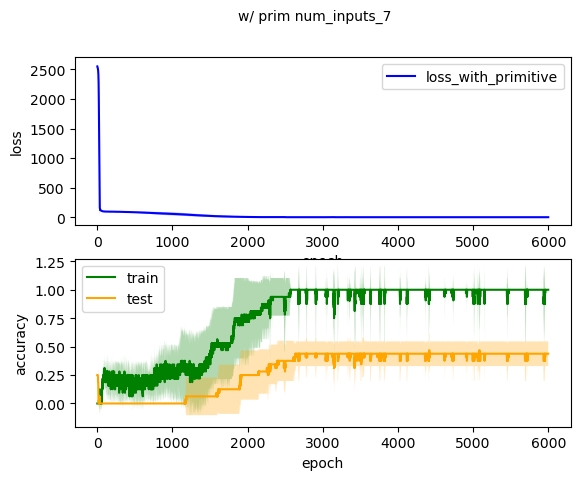

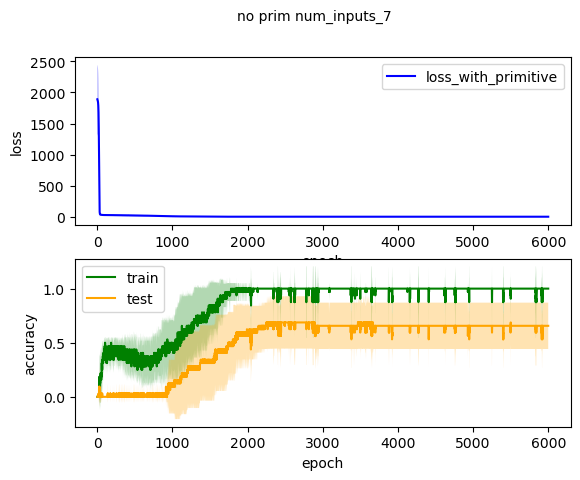

In [110]:
trainseqs = [
             ['A', ('+', 'A'), ('+', 'X'), 28],
             ['A', ('+', 'X'), ('+', 'A'), 28],
             ['X', ('+', 'A'), ('+', 'A'), 28],
             ['X', ('+', 'A'), ('+', 'X'), 14]
             ]

             

testseqs = [['X', ('+', 'X'), ('+', 'X'), 0],
            ['X', ('+', 'X'), ('+', 'A'), 14],
            ['A', ('+', 'X'), ('+', 'X'), 14],
            ['A', ('+', 'A'), ('+', 'A'), 42]
             ]

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss1'] for r in res])
acc_train = np.array([r['acc1'][:,0] for r in res]).T
acc_test = np.array([r['acc1'][:,1] for r in res]).T
mods = [r['mod1'] for r in res]
tests = [r['test1'] for r in res]
lossesx = np.hstack([r['loss2'] for r in res])
acc_trainx = np.array([r['acc2'][:,0] for r in res]).T
acc_testx = np.array([r['acc2'][:,1] for r in res]).T
modsx = [r['mod2'] for r in res]
testsx = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plotNNs([lossesx], [acc_trainx, acc_testx], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'no prim num_inputs_'+str(7), shift = 0)


time:  2.2756381154060366


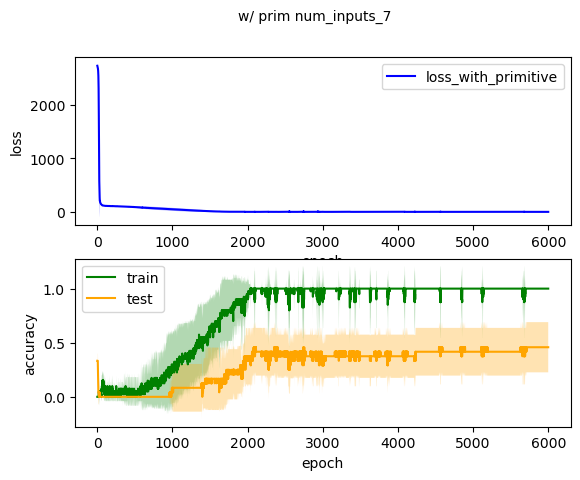

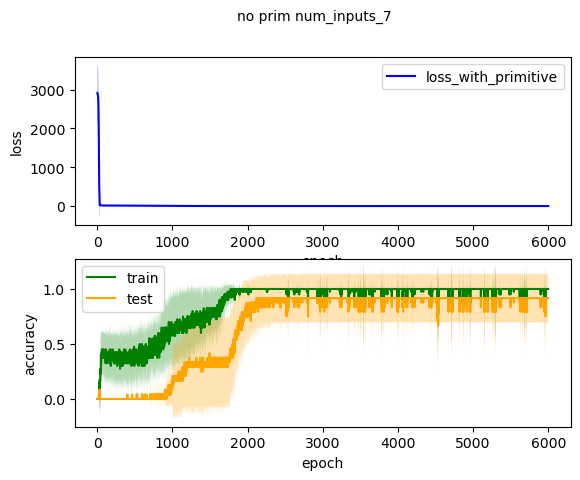

In [116]:
trainseqs = [['X', ('+', 'X'), ('+', 'A'), 14],
             ['A', ('+', 'A'), ('+', 'X'), 28],
             ['A', ('+', 'X'), ('+', 'A'), 28],
             ['X', ('+', 'A'), ('+', 'A'), 28],
             ['X', ('+', 'A'), ('+', 'X'), 14]
             ]

             

testseqs = [['X', ('+', 'X'), ('+', 'X'), 0],
            ['A', ('+', 'X'), ('+', 'X'), 14],
            ['A', ('+', 'A'), ('+', 'A'), 42]
             ]

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss1'] for r in res])
acc_train = np.array([r['acc1'][:,0] for r in res]).T
acc_test = np.array([r['acc1'][:,1] for r in res]).T
mods = [r['mod1'] for r in res]
tests = [r['test1'] for r in res]
lossesx = np.hstack([r['loss2'] for r in res])
acc_trainx = np.array([r['acc2'][:,0] for r in res]).T
acc_testx = np.array([r['acc2'][:,1] for r in res]).T
modsx = [r['mod2'] for r in res]
testsx = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plotNNs([lossesx], [acc_trainx, acc_testx], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'no prim num_inputs_'+str(7), shift = 0)


time:  2.073047383626302


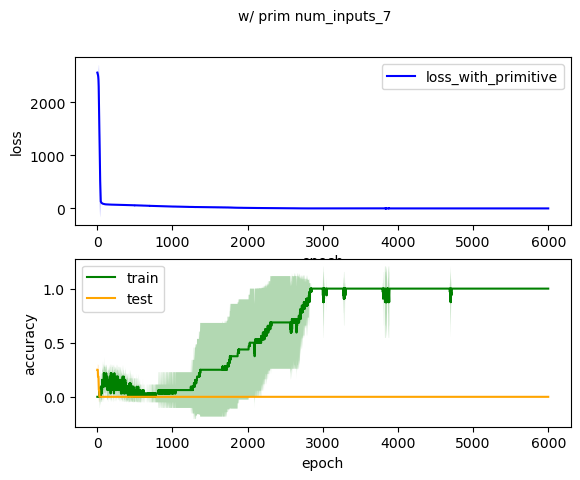

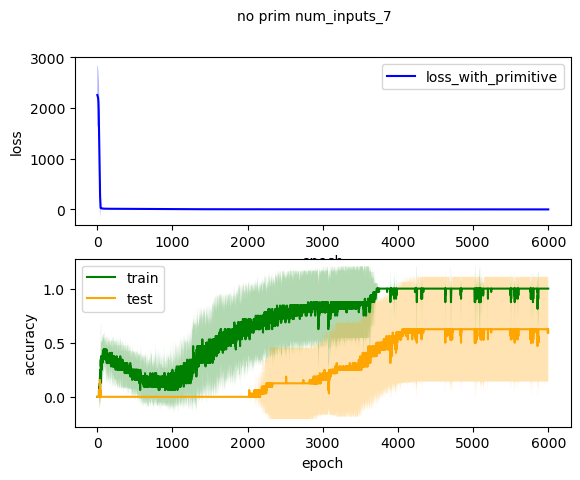

In [122]:
trainseqs = [['X', ('+', 'X'), ('+', 'A'), 14],
             ['A', ('+', 'A'), ('+', 'X'), 28],
             ['A', ('+', 'X'), ('+', 'A'), 28],
             ['X', ('+', 'A'), ('+', 'A'), 28]
             ]

             

testseqs = [['X', ('+', 'X'), ('+', 'X'), 0],
            ['A', ('+', 'X'), ('+', 'X'), 14],
            ['A', ('+', 'A'), ('+', 'A'), 42],
            ['X', ('+', 'A'), ('+', 'X'), 14]
             ]

t1 = time.time()
res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
t2 = time.time()
print('time: ', (t2-t1)/60)

losses = np.hstack([r['loss1'] for r in res])
acc_train = np.array([r['acc1'][:,0] for r in res]).T
acc_test = np.array([r['acc1'][:,1] for r in res]).T
mods = [r['mod1'] for r in res]
tests = [r['test1'] for r in res]
lossesx = np.hstack([r['loss2'] for r in res])
acc_trainx = np.array([r['acc2'][:,0] for r in res]).T
acc_testx = np.array([r['acc2'][:,1] for r in res]).T
modsx = [r['mod2'] for r in res]
testsx = [r['test2'] for r in res]

plotNNs([losses], [acc_train, acc_test], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'w/ prim num_inputs_'+str(7), shift = 0)
plotNNs([lossesx], [acc_trainx, acc_testx], \
        ['train', 'test'], colors = ['green', 'orange'], title = 'no prim num_inputs_'+str(7), shift = 0)


In [ ]:
# systematically try every sample of 4 training trials

In [178]:
epochs = 6000

In [180]:
all_seqs = [['X', ('+', 'X'), ('+', 'A'), 14],
             ['A', ('+', 'A'), ('+', 'X'), 28],
             ['A', ('+', 'X'), ('+', 'A'), 28],
             ['X', ('+', 'A'), ('+', 'A'), 28],
             ['X', ('+', 'X'), ('+', 'X'), 0],
             ['A', ('+', 'X'), ('+', 'X'), 14],
             ['A', ('+', 'A'), ('+', 'A'), 42],
             ['X', ('+', 'A'), ('+', 'X'), 14]
             ]

             
train_combos4 = list(itertools.combinations(all_seqs, 4))

reses4 = []
accs4 = []
rs4 = []
dfs4 = []
for i in range(len(train_combos)):
    print('#### combo: ', i, ' #########')
    trainseqs = train_combos4[i]
    testseqs = all_seqs.copy()
    for t in trainseqs:
        testseqs.remove(t)
    
    t1 = time.time()
    print('trainseqs: ', trainseqs)
    res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
    
    reses4.append(res)
    
    mods = [r['mod1'] for r in res]
    tests = [r['test1'] for r in res]
    
    modsx = [r['mod2'] for r in res]
    testsx = [r['test2'] for r in res]

    dfs1 = []
    dfs2 = []
    for i in range(len(mods)):
        df1 = test_preds(mods[i], [tests[i]], hidden_size)
        df2 = test_preds(modsx[i], [testsx[i]], hidden_size)
        dfs1.append(df1)
        dfs2.append(df2)
    all_dfs1 = pd.concat(dfs1) 
    all_dfs2 = pd.concat(dfs2) 
    all_dfs1['acc'] = np.round(all_dfs1['label']) == np.round(all_dfs1['pred'])
    all_dfs2['acc'] = np.round(all_dfs2['label']) == np.round(all_dfs2['pred'])

    acc = (all_dfs1.acc.mean(), all_dfs2.acc.mean())
    rvals = (r2_score(all_dfs1['pred'],all_dfs1['label']), r2_score(all_dfs2['pred'],all_dfs2['label']))
    print('acc: ', acc)
    print('rvals: ', rvals)
    accs4.append(acc)
    dfs4.append((all_dfs1, all_dfs2))
    rs4.append(rvals)
    
    t2 = time.time()
    print('time: ', (t2-t1)/60)

#### combo:  0  #########
trainseqs:  (['X', ('+', 'X'), ('+', 'A'), 14], ['A', ('+', 'A'), ('+', 'X'), 28], ['A', ('+', 'X'), ('+', 'A'), 28], ['X', ('+', 'A'), ('+', 'A'), 28])
acc:  (0.03125, 0.375)
rvals:  (0.47199908204398844, -3.845504809927303)
time:  2.1390881299972535
#### combo:  1  #########
trainseqs:  (['X', ('+', 'X'), ('+', 'A'), 14], ['A', ('+', 'A'), ('+', 'X'), 28], ['A', ('+', 'X'), ('+', 'A'), 28], ['X', ('+', 'X'), ('+', 'X'), 0])
acc:  (0.5625, 0.65625)
rvals:  (0.9650670261721909, -4.8241443595783675)
time:  2.0511474013328552
#### combo:  2  #########
trainseqs:  (['X', ('+', 'X'), ('+', 'A'), 14], ['A', ('+', 'A'), ('+', 'X'), 28], ['A', ('+', 'X'), ('+', 'A'), 28], ['A', ('+', 'X'), ('+', 'X'), 14])
acc:  (0.28125, 0.59375)
rvals:  (0.9709421209032261, -4.857364400981038)
time:  2.0453311006228128
#### combo:  3  #########
trainseqs:  (['X', ('+', 'X'), ('+', 'A'), 14], ['A', ('+', 'A'), ('+', 'X'), 28], ['A', ('+', 'X'), ('+', 'A'), 28], ['A', ('+', 'A'), ('+

acc:  (0.34375, 0.59375)
rvals:  (0.9253299329982232, -3.9304082078307703)
time:  6.994150984287262
#### combo:  31  #########
trainseqs:  (['X', ('+', 'X'), ('+', 'A'), 14], ['X', ('+', 'X'), ('+', 'X'), 0], ['A', ('+', 'X'), ('+', 'X'), 14], ['A', ('+', 'A'), ('+', 'A'), 42])
acc:  (0.5625, 0.78125)
rvals:  (0.8600260164694099, -2.6287426125421205)
time:  2.2019355495770774
#### combo:  32  #########
trainseqs:  (['X', ('+', 'X'), ('+', 'A'), 14], ['X', ('+', 'X'), ('+', 'X'), 0], ['A', ('+', 'X'), ('+', 'X'), 14], ['X', ('+', 'A'), ('+', 'X'), 14])
acc:  (0.28125, 0.78125)
rvals:  (0.96493531339325, -10.219687538411705)
time:  2.0281250794728596
#### combo:  33  #########
trainseqs:  (['X', ('+', 'X'), ('+', 'A'), 14], ['X', ('+', 'X'), ('+', 'X'), 0], ['A', ('+', 'A'), ('+', 'A'), 42], ['X', ('+', 'A'), ('+', 'X'), 14])
acc:  (0.40625, 0.84375)
rvals:  (0.8472863611466457, -2.8904479224998045)
time:  2.0287661512692767
#### combo:  34  #########
trainseqs:  (['X', ('+', 'X'), ('+',

acc:  (0.4375, 0.75)
rvals:  (0.7744198414383007, -7.169486603089718)
time:  2.033475987116496
#### combo:  61  #########
trainseqs:  (['A', ('+', 'X'), ('+', 'A'), 28], ['X', ('+', 'X'), ('+', 'X'), 0], ['A', ('+', 'X'), ('+', 'X'), 14], ['A', ('+', 'A'), ('+', 'A'), 42])
acc:  (0.09375, 0.4375)
rvals:  (-0.0032524774606303986, -1.0080649833902076)
time:  2.029329748948415
#### combo:  62  #########
trainseqs:  (['A', ('+', 'X'), ('+', 'A'), 28], ['X', ('+', 'X'), ('+', 'X'), 0], ['A', ('+', 'X'), ('+', 'X'), 14], ['X', ('+', 'A'), ('+', 'X'), 14])
acc:  (0.1875, 0.53125)
rvals:  (0.7703945097541154, -2.9043178711667026)
time:  2.1506555994351704
#### combo:  63  #########
trainseqs:  (['A', ('+', 'X'), ('+', 'A'), 28], ['X', ('+', 'X'), ('+', 'X'), 0], ['A', ('+', 'A'), ('+', 'A'), 42], ['X', ('+', 'A'), ('+', 'X'), 14])
acc:  (0.0, 0.0)
rvals:  (0.23813071764942662, -0.8126864484432625)
time:  2.1111762642860414
#### combo:  64  #########
trainseqs:  (['A', ('+', 'X'), ('+', 'A'), 2

In [200]:
all_seqs = [['X', ('+', 'X'), ('+', 'A'), 14],
             ['A', ('+', 'A'), ('+', 'X'), 28],
             ['A', ('+', 'X'), ('+', 'A'), 28],
             ['X', ('+', 'A'), ('+', 'A'), 28],
             ['X', ('+', 'X'), ('+', 'X'), 0],
             ['A', ('+', 'X'), ('+', 'X'), 14],
             ['A', ('+', 'A'), ('+', 'A'), 42],
             ['X', ('+', 'A'), ('+', 'X'), 14]
             ]

             
train_combos5 = list(itertools.combinations(all_seqs, 5))

reses5 = []
accs5 = []
rs5 = []
dfs5 = []
for i in range(len(train_combos)):
    print('#### combo: ', i, ' #########')
    trainseqs = train_combos5[i]
    testseqs = all_seqs.copy()
    for t in trainseqs:
        testseqs.remove(t)
    
    t1 = time.time()
    print('trainseqs: ', trainseqs)
    res  = Parallel(n_jobs = -1)(delayed(run_exp1)(trainseqs, testseqs) for i in range(num_sims))
    
    reses5.append(res)
    
    mods = [r['mod1'] for r in res]
    tests = [r['test1'] for r in res]
    
    modsx = [r['mod2'] for r in res]
    testsx = [r['test2'] for r in res]

    dfs1 = []
    dfs2 = []
    for i in range(len(mods)):
        df1 = test_preds(mods[i], [tests[i]], hidden_size)
        df2 = test_preds(modsx[i], [testsx[i]], hidden_size)
        dfs1.append(df1)
        dfs2.append(df2)
    all_dfs1 = pd.concat(dfs1) 
    all_dfs2 = pd.concat(dfs2) 
    all_dfs1['acc'] = np.round(all_dfs1['label']) == np.round(all_dfs1['pred'])
    all_dfs2['acc'] = np.round(all_dfs2['label']) == np.round(all_dfs2['pred'])

    acc = (all_dfs1.acc.mean(), all_dfs2.acc.mean())
    rvals = (r2_score(all_dfs1['pred'],all_dfs1['label']), r2_score(all_dfs2['pred'],all_dfs2['label']))
    print('acc: ', acc)
    print('rvals: ', rvals)
    accs5.append(acc)
    dfs5.append((all_dfs1, all_dfs2))
    rs5.append(rvals)
    
    t2 = time.time()
    print('time: ', (t2-t1)/60)

#### combo:  0  #########
trainseqs:  (['X', ('+', 'X'), ('+', 'A'), 14], ['A', ('+', 'A'), ('+', 'X'), 28], ['A', ('+', 'X'), ('+', 'A'), 28], ['X', ('+', 'A'), ('+', 'A'), 28], ['X', ('+', 'X'), ('+', 'X'), 0])
acc:  (0.5833333333333334, 1.0)
rvals:  (0.9901488226192743, 0.9994932511458053)
time:  2.3936722675959268
#### combo:  1  #########
trainseqs:  (['X', ('+', 'X'), ('+', 'A'), 14], ['A', ('+', 'A'), ('+', 'X'), 28], ['A', ('+', 'X'), ('+', 'A'), 28], ['X', ('+', 'A'), ('+', 'A'), 28], ['A', ('+', 'X'), ('+', 'X'), 14])
acc:  (0.5416666666666666, 0.9166666666666666)
rvals:  (0.9836836308514856, 0.9978886392381319)
time:  2.3070736010869344
#### combo:  2  #########
trainseqs:  (['X', ('+', 'X'), ('+', 'A'), 14], ['A', ('+', 'A'), ('+', 'X'), 28], ['A', ('+', 'X'), ('+', 'A'), 28], ['X', ('+', 'A'), ('+', 'A'), 28], ['A', ('+', 'A'), ('+', 'A'), 42])
acc:  (0.16666666666666666, 0.8333333333333334)
rvals:  (0.8086482938843947, 0.9930323459194859)
time:  2.317529547214508
#### com

acc:  (0.5, 0.875)
rvals:  (0.940879884438265, 0.9934951677501316)
time:  2.218265096346537
#### combo:  26  #########
trainseqs:  (['X', ('+', 'X'), ('+', 'A'), 14], ['A', ('+', 'X'), ('+', 'A'), 28], ['X', ('+', 'X'), ('+', 'X'), 0], ['A', ('+', 'X'), ('+', 'X'), 14], ['A', ('+', 'A'), ('+', 'A'), 42])
acc:  (0.2916666666666667, 0.6666666666666666)
rvals:  (0.9137240144404737, 0.9636178911727639)
time:  2.2183730363845826
#### combo:  27  #########
trainseqs:  (['X', ('+', 'X'), ('+', 'A'), 14], ['A', ('+', 'X'), ('+', 'A'), 28], ['X', ('+', 'X'), ('+', 'X'), 0], ['A', ('+', 'X'), ('+', 'X'), 14], ['X', ('+', 'A'), ('+', 'X'), 14])
acc:  (0.375, 0.5416666666666666)
rvals:  (0.9246722681984263, 0.9443893668291334)
time:  2.234286868572235
#### combo:  28  #########
trainseqs:  (['X', ('+', 'X'), ('+', 'A'), 14], ['A', ('+', 'X'), ('+', 'A'), 28], ['X', ('+', 'X'), ('+', 'X'), 0], ['A', ('+', 'A'), ('+', 'A'), 42], ['X', ('+', 'A'), ('+', 'X'), 14])
acc:  (0.7916666666666666, 0.7916666

acc:  (0.0, 0.625)
rvals:  (0.8436015388519331, 0.9797122155691065)
time:  2.4821000655492145
#### combo:  52  #########
trainseqs:  (['A', ('+', 'X'), ('+', 'A'), 28], ['X', ('+', 'A'), ('+', 'A'), 28], ['X', ('+', 'X'), ('+', 'X'), 0], ['A', ('+', 'A'), ('+', 'A'), 42], ['X', ('+', 'A'), ('+', 'X'), 14])
acc:  (0.625, 0.9166666666666666)
rvals:  (0.9462750244469872, 0.9969219666594141)
time:  2.563287882010142
#### combo:  53  #########
trainseqs:  (['A', ('+', 'X'), ('+', 'A'), 28], ['X', ('+', 'A'), ('+', 'A'), 28], ['A', ('+', 'X'), ('+', 'X'), 14], ['A', ('+', 'A'), ('+', 'A'), 42], ['X', ('+', 'A'), ('+', 'X'), 14])
acc:  (0.041666666666666664, 0.6666666666666666)
rvals:  (0.8024647905511915, 0.9788578558588589)
time:  2.89106818040212
#### combo:  54  #########
trainseqs:  (['A', ('+', 'X'), ('+', 'A'), 28], ['X', ('+', 'X'), ('+', 'X'), 0], ['A', ('+', 'X'), ('+', 'X'), 14], ['A', ('+', 'A'), ('+', 'A'), 42], ['X', ('+', 'A'), ('+', 'X'), 14])
acc:  (0.20833333333333334, 0.75)

In [216]:
sumax = np.array(accs5).sum(axis=1)

In [219]:
sumax.max()

1.6666666666666665

In [217]:
np.where(sumax == np.max(sumax))

(array([17]),)

Text(0.5, 1.0, 'with primitive training, R^2 = 0.03')

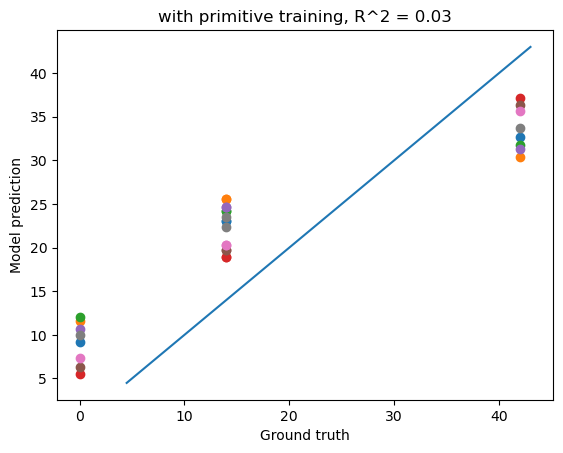

In [128]:
dfs1 = []
for i in range(len(mods)):
    df = test_preds(mods[i], [tests[i]], hidden_size)
    dfs1.append(df)
all_dfs1 = pd.concat(dfs1) 
preds, labs = all_dfs1['pred'], all_dfs1['label']
xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)

for d in dfs1:
    plt.scatter(d['label'], d['pred'])
plt.plot(xy,xy)
plt.xlabel('Ground truth')
plt.ylabel('Model prediction')
plt.title('with primitive training, R^2 = ' + str(round(r2_score(all_dfs1['pred'],all_dfs1['label']), 2)) )

Text(0.5, 1.0, 'with primitive training, R^2 = 0.69')

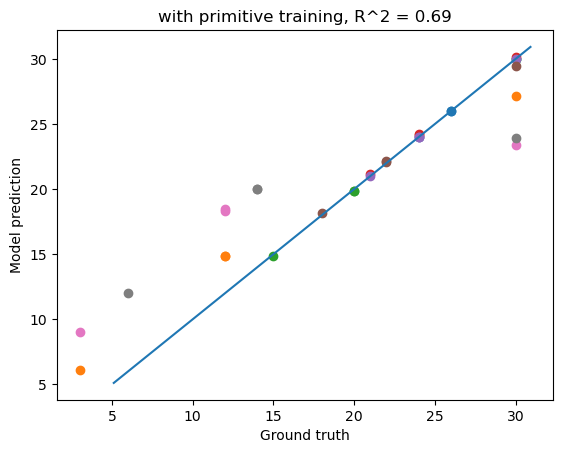

In [162]:
dfs2 = []
for i in range(len(modsx)):
    df = test_preds(modsx[i], [testsx[i]], hidden_size)
    dfs2.append(df)
all_dfs2 = pd.concat(dfs2) 
preds, labs = all_dfs2['pred'], all_dfs2['label']
xy = np.arange(np.min(preds)-1, np.max(labs)+1, 0.1)

for d in dfs2:
    plt.scatter(d['label'], d['pred'])
plt.plot(xy,xy)
plt.xlabel('Ground truth')
plt.ylabel('Model prediction')
plt.title('with primitive training, R^2 = ' + str(round(r2_score(all_dfs2['pred'],all_dfs2['label']), 2)) )

In [149]:
## find trials
accdfs = []
accdfsX = []
for i in range(len(tests)):
    df = seq_acc(mods[i], tests[i], hidden_size)
    accdfs.append(df)
    df = seq_acc(modsx[i], testsx[i], hidden_size)
    accdfsX.append(df)

In [156]:
(pd.concat(accdfs).acc.mean(), pd.concat(accdfsX).acc.mean())


(0.0, 0.59375)

In [150]:
accdfs

[                       trial  acc
 0  ['A', '+', 'A', '+', 'A']  0.0
 1  ['A', '+', 'X', '+', 'X']  0.0
 2  ['X', '+', 'A', '+', 'X']  0.0
 3  ['X', '+', 'X', '+', 'X']  0.0,
                        trial  acc
 0  ['X', '+', 'A', '+', 'X']  0.0
 1  ['A', '+', 'X', '+', 'X']  0.0
 2  ['A', '+', 'A', '+', 'A']  0.0
 3  ['X', '+', 'X', '+', 'X']  0.0,
                        trial  acc
 0  ['A', '+', 'A', '+', 'A']  0.0
 1  ['X', '+', 'A', '+', 'X']  0.0
 2  ['A', '+', 'X', '+', 'X']  0.0
 3  ['X', '+', 'X', '+', 'X']  0.0,
                        trial  acc
 0  ['A', '+', 'X', '+', 'X']  0.0
 1  ['X', '+', 'X', '+', 'X']  0.0
 2  ['A', '+', 'A', '+', 'A']  0.0
 3  ['X', '+', 'A', '+', 'X']  0.0,
                        trial  acc
 0  ['A', '+', 'X', '+', 'X']  0.0
 1  ['A', '+', 'A', '+', 'A']  0.0
 2  ['X', '+', 'A', '+', 'X']  0.0
 3  ['X', '+', 'X', '+', 'X']  0.0,
                        trial  acc
 0  ['X', '+', 'A', '+', 'X']  0.0
 1  ['A', '+', 'X', '+', 'X']  0.0
 2  ['A', '+', 

In [132]:
accdfsX

[                       trial  acc
 0  ['X', '+', 'A', '+', 'X']  1.0
 1  ['A', '+', 'A', '+', 'A']  1.0
 2  ['X', '+', 'X', '+', 'X']  1.0
 3  ['A', '+', 'X', '+', 'X']  1.0,
                        trial  acc
 0  ['X', '+', 'A', '+', 'X']  0.0
 1  ['A', '+', 'A', '+', 'A']  0.0
 2  ['X', '+', 'X', '+', 'X']  0.0
 3  ['A', '+', 'X', '+', 'X']  0.0,
                        trial  acc
 0  ['A', '+', 'A', '+', 'A']  1.0
 1  ['X', '+', 'A', '+', 'X']  1.0
 2  ['A', '+', 'X', '+', 'X']  1.0
 3  ['X', '+', 'X', '+', 'X']  1.0,
                        trial  acc
 0  ['X', '+', 'A', '+', 'X']  1.0
 1  ['A', '+', 'X', '+', 'X']  1.0
 2  ['A', '+', 'A', '+', 'A']  1.0
 3  ['X', '+', 'X', '+', 'X']  1.0,
                        trial  acc
 0  ['X', '+', 'X', '+', 'X']  1.0
 1  ['A', '+', 'A', '+', 'A']  1.0
 2  ['A', '+', 'X', '+', 'X']  1.0
 3  ['X', '+', 'A', '+', 'X']  1.0,
                        trial  acc
 0  ['A', '+', 'X', '+', 'X']  1.0
 2  ['X', '+', 'X', '+', 'X']  1.0
 3  ['X', '+', 

loss: 0.0 
loss: 0.0 
